## Описание проекта

Нам предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются.


Описание полей данных
- `name` - Название стартапа
- `category_list` - Список категорий, к которым относится стартап
- `funding_total_usd` - Общая сумма финансирования в USD
- `status` - Статус стартапа (закрыт или действующий), **целевой признак**
- `country_code` - Код страны
- `state_code` - Код штата
- `region` - Регион
- `city` - Город
- `funding_rounds` - Количество раундов финансирования
- `founded_at` - Дата основания
- `first_funding_at` - Дата первого раунда финансирования
- `last_funding_at` - Дата последнего раунда финансирования
- `closed_at` - Дата закрытия стартапа (если применимо)
- `lifetime` - Время существования стартапа в днях

In [5]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from ydata_profiling import ProfileReport

import phik
import shap

 ## Загрузка и проверка данных

In [6]:
# Импортируем тренировочный датасет
df = pd.read_csv('data/startup_train.csv',
                 parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])

# Импортируем тестовый датасет
test_df = pd.read_csv('data/startup_test.csv',
                      parse_dates=['first_funding_at', 'last_funding_at', ])

In [7]:
# Выводим информацию о тренировочном датасете
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaT
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT


Мы видим, что большинство данных у нас приведены к корректному типу данных. Мы можем привести столбец `status` к булевому типу, так как он принимает всего 2 значения: closed и operating. Сделаем это позже, используя label encoder. У нас в тренировочных данных присутствует столбец `closed_at`. Удалим его, так как это будет являться утечкой целевого признака

In [8]:
# Выводим информацию о тестовом датасете
print(test_df.info())
test_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB
None


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2012-07-01,2012-07-01,2267
13121,GlobaTrek,Software,NaN,USA,CA,SF Bay Area,Mountain View,1,2013-10-01,2013-10-01,2192
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,WA,Seattle,Seattle,3,2008-09-01,2011-06-28,2922
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,NY,New York City,New York,2,2014-09-27,2014-11-04,1386


В тестовом датасете данные все данные так же приведены к правильному типу данных. Столбец `lifetime` нам придется удалить, так как он не фигурирует в обучающих данных. Мы могли бы посчитать `lifetime` в тренировочной таблице, однако это будет утечкой целевого признака, так как для компаний, которые все еще не закрылись, данных не будет

### Вывод:

Мы видим, что большинство данных у нас приведены к корректному типу данных. Мы можем привести столбец `status` к булевому типу, так как он принимает всего 2 значения: closed и operating. Сделаем это позже, используя label encoder. У нас в тренировочных данных присутствует столбец `closed_at`. Удалим его, так как это будет являться утечкой целевого признака.

В тестовом датасете данные все данные так же приведены к правильному типу данных. Столбец `lifetime` нам придется удалить, так как он не фигурирует в обучающих данных. Мы могли бы посчитать `lifetime` в тренировочной таблице, однако это будет утечкой целевого признака, так как для компаний, которые все еще не закрылись, данных не будет


## Предобработка данных:

Посмотрим на наличие выбросов и пропусков. Обработаем их, если возможно

In [9]:
# Объявим список числовых, категориальных, и столбцов с датой
num_col_names = ['funding_total_usd', 'funding_rounds']
cat_col_names = ['category_list', 'country_code', 'state_code', 'region', 'city']
date_col_names = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']

In [10]:
# # Создаем отчет до обработки тренировочных данных, используя ydata-profiling
# profile = ProfileReport(df, title='Report before train data processing')
#
# # Сохраняем отчет
# profile.to_file('reports/report_before_train_data_processing.html')
#
# # Выводим отчет
# profile.to_notebook_iframe()

In [11]:
# Выводим информацию о пропусках и уникальных значениях
pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_percent': round(df.isna().sum() / df.shape[0] * 100, 1),

    'unique_count': df.nunique(),
    'unique_percent': round(df.nunique() / df.shape[0] * 100, 1),
})

,missing_count,missing_percent,unique_count,unique_percent
name,1,0.0,52515,100.0
category_list,2465,4.7,22105,42.1
funding_total_usd,10069,19.2,15551,29.6
status,0,0.0,2,0.0
country_code,5502,10.5,134,0.3
state_code,6763,12.9,300,0.6
region,6359,12.1,1036,2.0
city,6359,12.1,4477,8.5
funding_rounds,0,0.0,19,0.0
founded_at,0,0.0,5402,10.3


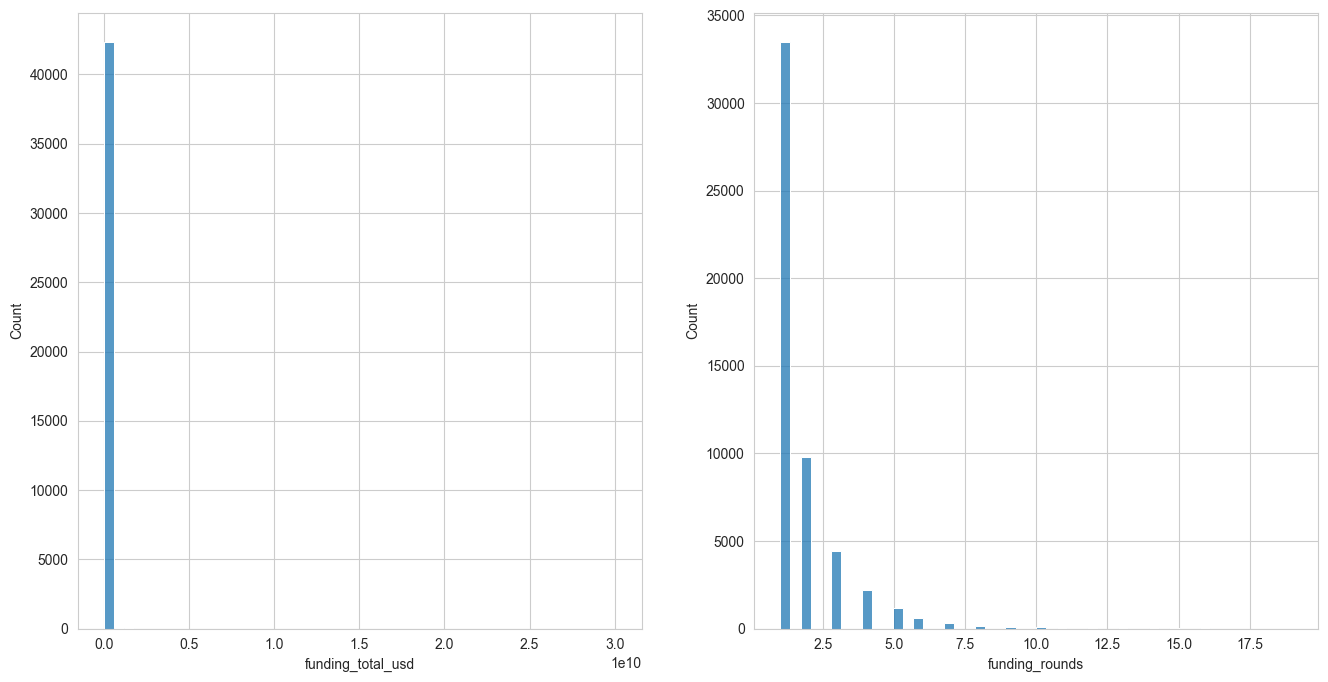

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Выводим гистограмму числовых значений
for i in range(len(num_col_names)):
    sns.histplot(data=df, x=num_col_names[i],bins=50, ax=axes[i])

plt.show()

Рассмотрим столбцы, которые у нас есть
- `name` — в данном столбце у нас всего один пропуск, но эта это никак не повлияет на обучение модели, оставим все как есть
- `category_list` — в данном столбце у нас отсутствует 4.7% данных. Всего там 44% уникальных значений. Скорее всего пропуски в данном столбце мы заполним модой
- `funding_total_usd` — в данном столбце у нас отсутствует 19.2% данных. Так же по гистограмме видно, что там присутствуют выбросы. Рассмотрим это детальнее с помощью boxplot
- `status` — в данном столбце у нас представлен целевой признак. 90% компаний все еще работают, в то время как 10% компаний закрылись
- `country_code`— в данном столбце у нас отсутствует 10.5% данных. Всего там 134 уникальных значения. Пропуски мы заполним, медианным значением.
- `state_code`— в данном столбце у нас отсутствует 13% данных. Всего там 300 уникальных значений. Пропуски мы заполним медианным значением, предварительно сгруппировав данные по `county_code`
- `region`— в данном столбце у нас отсутствует 12% данных. Всего там 1036 уникальных значений. Пропуски мы заполним модой, сгруппировав `state_code`
- `city` — в данном столбце у нас отсутствует 12% данных. Всего там 4477 уникальных значений. Пропуски мы заполним модой, сгруппировав `city`
- `funding_rounds`— в данном столбце у нас нет пропусков, однако присутствуют выбросы. Рассмотрим это детальнее с помощью boxplot
- `founded_at` — в данном столбце у нас нет пропусков и выбросов. Гистограмма выглядит так, потому что в ранние годы либо было сильно меньше стартапов, либо их регистрация не фиксировалась
- `first_funding_at` — в данном столбце у нас аналогично предыдущему
- `last_funding_at` — в данном столбце у нас все аналогично предыдущему
- `closed_at` — в данном столбце у нас отсутствует 90% данных, но этот столбец понадобится нам только для исследовательского анализа

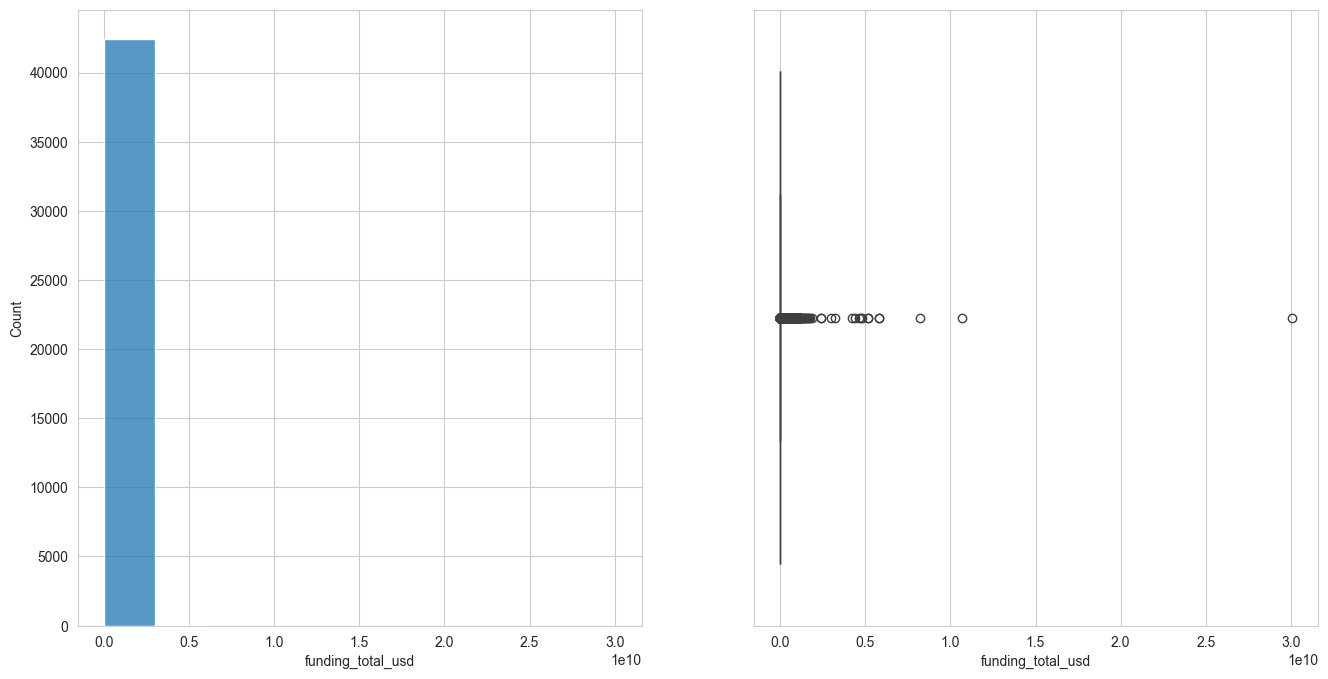

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.histplot(data=df, x='funding_total_usd', bins=10, ax=ax[0])
sns.boxplot(data=df, x='funding_total_usd', ax=ax[1])

plt.show()

Мы видим, что у нас присутствуют выбросы, которые вызваны даже если не вызваны ошибкой, то все равно помешают обучению модели. Остальные выбросы мы оставим, чтобы модель не обучалась в "идеальных" условиях. На первый взгляд, примерно 10-20 самых больших значений являются "критическими" выбросами. Посмотрим и удалим их

In [14]:
# Смотрим самые большие значение и количество раундов финансирования
df.sort_values(by=['funding_total_usd'], ascending=False)[['funding_total_usd', 'funding_rounds']]

,funding_total_usd,funding_rounds
39186,3.007950e+10,5
21241,1.066494e+10,1
4557,8.207450e+09,13
15976,5.820000e+09,6
36634,5.800000e+09,1
...,...,...
52499,NaN,3
52502,NaN,1
52507,NaN,1
52508,NaN,1


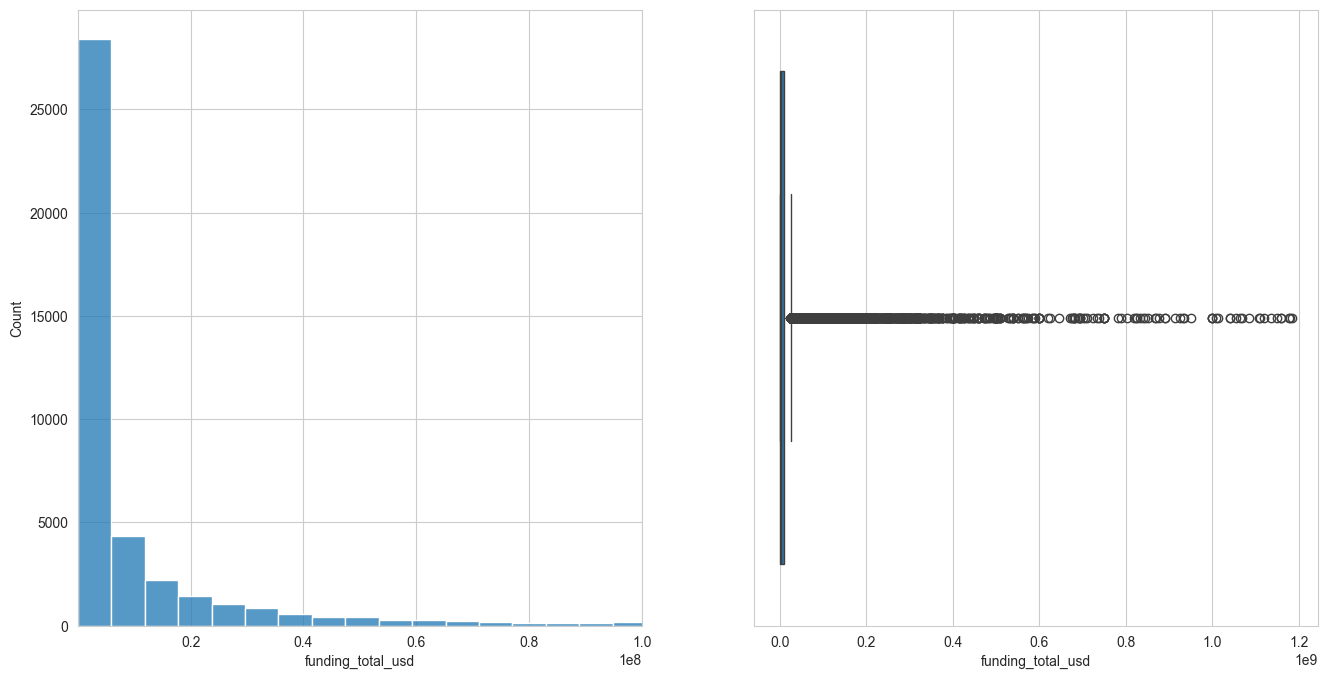

In [15]:
# Удаляем первые 30 самых больших значений
df = df.sort_values('funding_total_usd', ascending=False).iloc[30:]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].set_xlim(1, 100000000)
sns.histplot(data=df, x='funding_total_usd', bins=200, ax=ax[0])

sns.boxplot(data=df, x='funding_total_usd', ax=ax[1])

plt.show()

In [18]:
# Смотрим уникальные значение кода страны
df['country_code'].unique()

array(['USA', 'IND', 'DEU', 'CHN', 'SWE', 'CAN', nan, 'GBR', 'ARE', 'HKG',
       'GRD', 'NLD', 'MYS', 'SGP', 'RUS', 'BRA', 'JPN', 'BMU', 'ESP',
       'NZL', 'IDN', 'DNK', 'LUX', 'CHE', 'MUS', 'FRA', 'NOR', 'ZAF',
       'ISR', 'TGO', 'AUS', 'BEL', 'MEX', 'IRL', 'TUR', 'NGA', 'FIN',
       'PHL', 'AUT', 'PAK', 'KOR', 'TWN', 'EGY', 'VNM', 'CZE', 'ITA',
       'POL', 'TAN', 'PRT', 'ARG', 'KEN', 'COL', 'THA', 'GIB', 'LTU',
       'MAF', 'ARM', 'CYM', 'PER', 'CHL', 'EST', 'GHA', 'KNA', 'PAN',
       'ISL', 'KWT', 'MNE', 'MLT', 'SVN', 'KAZ', 'URY', 'BGR', 'BAH',
       'TTO', 'HUN', 'LIE', 'UKR', 'ROM', 'GRC', 'LVA', 'CYP', 'JOR',
       'SVK', 'GGY', 'TUN', 'SEN', 'LBN', 'UGA', 'LAO', 'SOM', 'MAR',
       'BWA', 'IRN', 'HRV', 'PRI', 'SRB', 'JAM', 'BGD', 'NIC', 'MCO',
       'VEN', 'SAU', 'CRI', 'KHM', 'BHR', 'ECU', 'DZA', 'CMR', 'SLV',
       'BLM', 'MMR', 'ALB', 'DOM', 'NPL', 'AZE', 'BLZ', 'QAT', 'RWA',
       'GTM', 'UZB', 'GEO', 'BLR', 'MDA', 'SYC', 'ZWE', 'PRY', 'ZMB',
       'OMN', '

In [26]:
print(df['country_code'].isna().sum())
df['country_code'].value_counts()

5500


country_code
USA    29686
GBR     2925
CAN     1540
IND     1274
CHN     1233
       ...  
UZB        1
PSE        1
OMN        1
BRN        1
JEY        1
Name: count, Length: 134, dtype: int64

In [27]:
# Посмотрим, какие данные в других столбцах для записей с пропусками в столбце country_code
df.loc[df['country_code'].isna()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
47338,ZhongAn,Insurance,931300000.0,operating,NaN,NaN,NaN,NaN,1,2013-01-01,2015-06-12,2015-06-12,NaT
31092,Open Environment Corporation,Computers|Software|Technology,870578950.0,closed,NaN,NaN,NaN,NaN,2,1992-01-01,1994-12-01,2001-01-01,2002-06-26
49067,Apollo Aviation Group,Banking|Finance|Investment Management,833000000.0,operating,NaN,NaN,NaN,NaN,1,2014-01-07,2015-10-07,2015-10-07,NaT
2954,Intime Retail,E-Commerce,692000000.0,operating,NaN,NaN,NaN,NaN,1,1998-01-01,2014-03-01,2014-03-01,NaT
29972,Magna Energy,Energy|Oil and Gas|Services,500000000.0,closed,NaN,NaN,NaN,NaN,1,2014-05-14,2015-06-22,2015-06-22,2016-08-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52394,Ogg Trading,NaN,NaN,operating,NaN,NaN,NaN,NaN,1,2014-01-26,2015-06-01,2015-06-01,NaT
52404,Beach Bum,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2014-08-13,2015-05-18,2015-05-18,2017-03-30
52419,"iSend, LLC",NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2007-01-01,2008-05-28,2008-05-28,2009-10-03
52420,Deutsche Startups,News|Startups,NaN,operating,NaN,NaN,NaN,NaN,1,2006-08-18,2007-04-08,2007-04-08,NaT


Мы видим, что данные, с пропуском в столбце `country_code`все еще валидны, поэтому нам нужно заполнить пропуски. Сделаем это, используя моду.

In [32]:
# Заполняем пропуски модой
df['country_code'] = df['country_code'].fillna(df['country_code'].mode()[0])

# Проверяем, остались ли у нас пропуски в данном столбце
df['country_code'].isna().sum()

np.int64(0)

In [17]:
# # Создаем отчет до обработки тестовых данных, используя ydata-profiling
# profile = ProfileReport(test_df, title='Report before test data processing')
#
# # Сохраняем отчет
# profile.to_file('reports/report_before_test_data_processing.html')
#
# # Выводим отчет
# profile.to_notebook_iframe()